# Attack Examples on GTSRB

In [1]:
# Specify visible cuda device
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

from parameters import *
from lib.utils import *
from lib.keras_utils import *
from lib.RandomTransform import *
from lib.OptCarlini import *
from lib.OptTransform import *

Using TensorFlow backend.


### Initialize Model

In [3]:
# Build and load trained model
model = built_mltscl()
model.load_weights(WEIGTHS_PATH)

# Load dataset
x_train, y_train, x_val, y_val, x_test, y_test = load_dataset_GTSRB(
    n_channel=N_CHANNEL)

# Convert labels to one-hot encoding
y_train = keras.utils.to_categorical(y_train, NUM_LABELS)
y_test = keras.utils.to_categorical(y_test, NUM_LABELS)
y_val = keras.utils.to_categorical(y_val, NUM_LABELS)

# Read sign names
signnames = read_csv("./input_data/signnames.csv").values[:, 1]

In [4]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 32, 32, 32)    2432        input_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 32, 32, 32)    0           conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 16, 16, 32)    0           dropout_1[0][0]                  
___________________________________________________________________________________________

### Load data

In [5]:
SAMPLE_IMG_DIR = './traffic_sign_samples'
SAMPLE_LABEL = './traffic_sign_samples/samples_label.txt'

In [6]:
# Load sample images, labels and masks
x_smp, x_smp_full, y_smp, masks, masks_full = load_samples(SAMPLE_IMG_DIR, SAMPLE_LABEL)

In [31]:
# Set target class to attack
tg = 10
print "Target class: " + signnames[tg]
# Set number of samples
size = 10

y_target = np.zeros((len(x_test))) + tg
y_target = keras.utils.to_categorical(y_target, NUM_LABELS)

# Filter samples (originally misclassified, originally classified as target)
x_fil, y_fil, del_id = filter_samples(model, x_smp, y_smp, y_target=y_target)
x_fil_full = np.delete(x_smp_full, del_id, axis=0)
masks_fil = np.delete(masks, del_id, axis=0)
masks_fil_full = np.delete(masks_full, del_id, axis=0)

# Set samples to attack (choose some samples by random)
ind = np.random.choice(range(len(y_fil)), size=size)
x_ben = np.copy(x_fil[ind])
x_ben_full = np.copy(x_fil_full[ind])
y_ben = np.copy(y_fil[ind])
y_tg = np.copy(y_target[ind])
masks_ben = np.copy(masks_fil[ind])
masks_ben_full = np.copy(masks_fil_full[ind])

Target class: No passing for vechiles over 3.5 metric tons


## Attack Examples

### Fast Gradient

In [48]:
# Specify list of magnitudes
mag_list = np.linspace(1.0, 2.0, 6)
x_fg = fg(model, x_ben, y_tg, mag_list, target=True, mask=masks_ben)

['Original class: No vechiles']


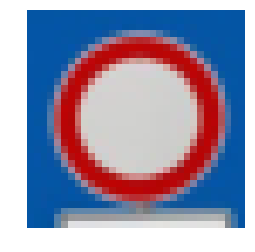

['Adversarial class: Speed limit (120km/h)']


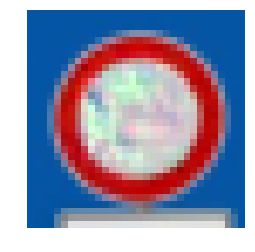

In [61]:
im = x_ben[0]
print "Original class: " + signnames[predict(model, im)]
plt.imshow(im)
plt.axis('off')
plt.show()

im = x_fg[5, 0]
print "Adversarial class: " + signnames[predict(model, im)]
plt.imshow(im)
plt.axis('off')
plt.show()

### Iterative Attack
Iterative steps in gradient direction

In [53]:
x_it = iterative(model, x_ben, y_tg, n_step=32, step_size=0.05, target=True, mask=masks_ben)

lib/utils.py:421: RuntimeWarning: divide by zero encountered in divide
  grad /= np.linalg.norm(grad)
lib/utils.py:421: RuntimeWarning: invalid value encountered in divide
  grad /= np.linalg.norm(grad)


['Original class: No vechiles']


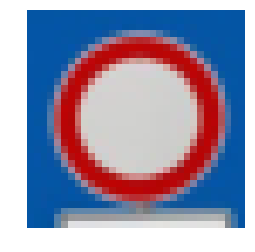

['Adversarial class: Speed limit (100km/h)']


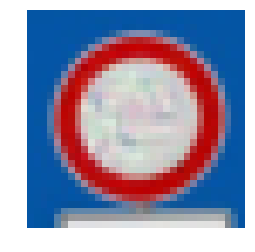

In [54]:
im = x_ben[0]
print "Original class: " + signnames[predict(model, im)]
plt.imshow(im)
plt.axis('off')
plt.show()

im = x_it[0]
print "Adversarial class: " + signnames[predict(model, im)]
plt.imshow(im)
plt.axis('off')
plt.show()

### Optimize Attack

In [55]:
# Initialize optimizer
opt = OptCarlini(model, c=1, lr=0.01, target=True, use_bound=False, init_scl=0.1,
                 loss_op=0, var_change=True, k=5)
# Run optimizer on sample (only take one sample at a time)
x_adv, norm = opt.optimize(x_ben[0], y_tg[0], n_step=5000, prog=True, mask=masks_ben[0])
# Run optimier with constant search
#x_adv, norm = opt.optimize_search(x_ben[0], y_tg[0], n_step=5000, search_step=10, prog=True, mask=masks_ben[0])

Step: 0, norm=12.276, loss=57.971, obj=70.247
Step: 50, norm=12.316, loss=-5.000, obj=7.316
Step: 100, norm=12.073, loss=-5.000, obj=7.073
Step: 150, norm=11.769, loss=-5.000, obj=6.769
Step: 200, norm=11.428, loss=-5.000, obj=6.428
Step: 250, norm=11.060, loss=-5.000, obj=6.060
Step: 300, norm=10.676, loss=-5.000, obj=5.676
Step: 350, norm=10.414, loss=-5.000, obj=5.414
Step: 400, norm=10.087, loss=-5.000, obj=5.087
Step: 450, norm=9.719, loss=-5.000, obj=4.719
Step: 500, norm=9.350, loss=-5.000, obj=4.350
Step: 550, norm=8.982, loss=-5.000, obj=3.982
Step: 600, norm=8.617, loss=-5.000, obj=3.617
Step: 650, norm=8.256, loss=-5.000, obj=3.256
Step: 700, norm=7.900, loss=-5.000, obj=2.900
Step: 750, norm=7.550, loss=-5.000, obj=2.550
Step: 800, norm=7.310, loss=-5.000, obj=2.310
Step: 850, norm=6.988, loss=-5.000, obj=1.988
Step: 900, norm=6.671, loss=-5.000, obj=1.671
Step: 950, norm=6.361, loss=-5.000, obj=1.361
Step: 1000, norm=6.184, loss=-5.000, obj=1.184
Step: 1050, norm=5.903, lo

['Original class: No vechiles']


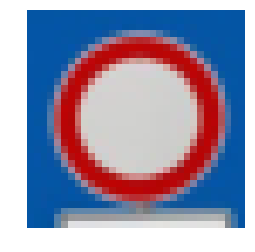

['Adversarial class: No passing for vechiles over 3.5 metric tons']


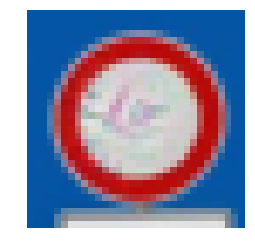

In [56]:
im = x_ben[0]
print "Original class: " + signnames[predict(model, im)]
plt.imshow(im)
plt.axis('off')
plt.show()

im = x_adv
print "Adversarial class: " + signnames[predict(model, im)]
plt.imshow(im)
plt.axis('off')
plt.show()

### Optimize with Transformation

In [57]:
# Initialize optimizer
opt = OptTransform(model, c=1, lr=0.01, target=True, use_bound=False, init_scl=0.1,
                   loss_op=0, var_change=True, k=5, batch_size=32)
# Run optimizer on sample
x_adv, norm = opt.optimize(x_ben[0], y_tg[0], n_step=5000, prog=True, mask=masks_ben[0])
# Run optimier with constant search
#x_adv, norm = opt.optimize_search(x_ben[0], y_tg[0], n_step=5000, search_step=10, prog=True, mask=masks_ben[0])

Step: 0, norm=12.247, loss=50.082, obj=62.329
Step: 50, norm=12.210, loss=-5.000, obj=7.210
Step: 100, norm=11.957, loss=-5.000, obj=6.957
Step: 150, norm=11.646, loss=-5.000, obj=6.646
Step: 200, norm=11.297, loss=-5.000, obj=6.297
Step: 250, norm=10.924, loss=-5.000, obj=5.924
Step: 300, norm=10.536, loss=-5.000, obj=5.536
Step: 350, norm=10.139, loss=-5.000, obj=5.139
Step: 400, norm=9.738, loss=-5.000, obj=4.738
Step: 450, norm=9.337, loss=-5.000, obj=4.337
Step: 500, norm=8.937, loss=-5.000, obj=3.937
Step: 550, norm=8.689, loss=-5.000, obj=3.689
Step: 600, norm=8.365, loss=-5.000, obj=3.365
Step: 650, norm=8.025, loss=-5.000, obj=3.025
Step: 700, norm=7.691, loss=-5.000, obj=2.691
Step: 750, norm=7.363, loss=-5.000, obj=2.363
Step: 800, norm=7.042, loss=-5.000, obj=2.042
Step: 850, norm=6.728, loss=-5.000, obj=1.728
Step: 900, norm=6.422, loss=-5.000, obj=1.422
Step: 950, norm=6.123, loss=-5.000, obj=1.123
Step: 1000, norm=5.832, loss=-5.000, obj=0.832
Step: 1050, norm=5.693, los

['Original class: No vechiles']


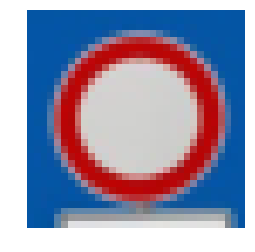

['Adversarial class: No passing for vechiles over 3.5 metric tons']


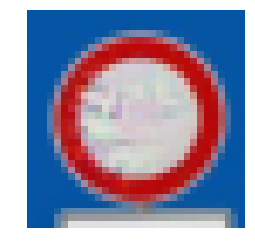

In [58]:
im = x_ben[0]
print "Original class: " + signnames[predict(model, im)]
plt.imshow(im)
plt.axis('off')
plt.show()

im = x_adv
print "Adversarial class: " + signnames[predict(model, im)]
plt.imshow(im)
plt.axis('off')
plt.show()

In [60]:
# Evaluate each attack, return a list of adv success rate
print eval_adv(model, x_fg, y_tg, target=True)
print eval_adv(model, x_it, y_tg, target=True)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.0


## Appendix

### Model trainer

In [7]:
# Build model
model = built_mltscl()

# Load dataset
x_train, y_train, x_val, y_val, x_test, y_test = load_dataset_GTSRB(
    n_channel=N_CHANNEL, train_file_name='train_extended.p')

y_train = keras.utils.to_categorical(y_train, NUM_LABELS)
y_test = keras.utils.to_categorical(y_test, NUM_LABELS)
y_val = keras.utils.to_categorical(y_val, NUM_LABELS)

In [10]:
filepath = './weights.{epoch:02d}-{val_loss:.2f}.hdf5'
modelCheckpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, 
                                                  save_best_only=False, save_weights_only=False, 
                                                  mode='auto', period=1)
earlyStop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, 
                                          verbose=0, mode='auto')

In [14]:
model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCH, verbose=1, 
          callbacks=[modelCheckpoint, earlyStop], validation_data=(x_val, y_val), 
          shuffle=True, initial_epoch=0)

Train on 695980 samples, validate on 4410 samples
Epoch 1/100
695980/695980 [==============================] - 240s - loss: 0.7197 - acc: 0.8864 - val_loss: 0.5842 - val_acc: 0.9404
Epoch 2/100
695980/695980 [==============================] - 235s - loss: 0.5336 - acc: 0.9393 - val_loss: 0.4748 - val_acc: 0.9574
Epoch 3/100
695980/695980 [==============================] - 235s - loss: 0.4958 - acc: 0.9509 - val_loss: 0.4832 - val_acc: 0.9565
Epoch 4/100
695980/695980 [==============================] - 239s - loss: 0.4789 - acc: 0.9572 - val_loss: 0.4538 - val_acc: 0.9719
Epoch 5/100
695980/695980 [==============================] - 235s - loss: 0.4607 - acc: 0.9607 - val_loss: 0.4437 - val_acc: 0.9671
Epoch 6/100
390752/695980 [===============>..............] - ETA: 102s - loss: 0.4546 - acc: 0.9624

KeyboardInterrupt: 